# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. 

###############################################

Tested various algorithms with different parameter combinations, such as Logistic Regression, Random Forest, XGBoost, LightGBM, and Neural Network. To prevent overfitting, we employed 5-fold cross-validation during the selection process ,and calculated the average FDR at a 3% rejection rate to reduce the effect of randomness. The average FDR score was then used to compare the performance of different models. After comparing the results, LightGBM exhibited the highest FDR on the testing data and was selected as the final model.
The LightGBM Classifier with parameters: max_depth=6, n_estimators=1000, num_leaves=10, and learning_rate=0.05, was the best and final model. The FDR scores for this model on training, testing, and OOT data were 53.00%, 52.80%, and 50.07%, respectively. (Taking number of variables =20)

##################################################

In [1]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")



# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.11.0


In [2]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(1000000, 22)
CPU times: user 586 ms, sys: 149 ms, total: 735 ms
Wall time: 797 ms


,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,...,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60,record,fraud_label
0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
2,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,0.0
3,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,0.0
4,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,0.0


In [43]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 20

vars.rename(columns={'record':'Recnum'},inplace=True)
vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'fulladdress_day_since',
 'name_dob_count_30',
 'address_unique_count_for_name_homephone_60',
 'fulladdress_unique_count_for_dob_homephone_3',
 'address_unique_count_for_homephone_name_dob_30',
 'address_unique_count_for_ssn_name_dob_14',
 'address_day_since',
 'address_count_14',
 'address_count_7',
 'address_count_0_by_30',
 'address_unique_count_for_homephone_name_dob_60',
 'fulladdress_count_0_by_30',
 'address_unique_count_for_ssn_zip5_60',
 'address_unique_count_for_ssn_name_60',
 'address_unique_count_for_ssn_firstname_60',
 'address_unique_count_for_ssn_name_dob_60',
 'address_unique_count_for_dob_homephone_60',
 'address_unique_count_for_ssn_homephone_60',
 'address_unique_count_for_ssn_lastname_60',
 'address_unique_count_for_ssn_60']

In [44]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,...,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60
0,1.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2.0,1.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,4.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,5.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,...,1.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [45]:
vars.shape

(1000000, 22)

In [46]:
vars['Fraud'].sum()

14393.0

In [48]:
vars.shape

(1000000, 22)

In [49]:
vars.describe()

,Recnum,Fraud,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,...,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,0.014393,325.060480,1.046384,1.066381,1.028348,1.052878,1.042172,320.117207,1.054768,...,1.069813,29.489603,1.063754,1.063893,1.063768,1.069072,1.069604,1.066676,1.063742,1.063595
std,288675.278932,0.119104,99.097485,0.497036,0.701078,0.539675,0.641431,0.607350,104.836655,0.618082,...,0.703726,2.834776,0.699405,0.699542,0.699434,0.703730,0.703504,0.701785,0.699411,0.699296
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.304348,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,250000.750000,0.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,...,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,500000.500000,0.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,...,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,750000.250000,0.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,...,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1000000.000000,1.000000,365.000000,34.000000,30.000000,30.000000,30.000000,30.000000,365.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [50]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0


## Scale and truncate field values

In [51]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,325.060480,1.046384,1.066381,1.028348,1.052878,1.042172,320.117207,1.054768,1.042577,29.358254,1.069813,29.489603,1.063754,1.063893,1.063768,1.069072,1.069604,1.066676,1.063742,1.063595
std,99.097485,0.497036,0.701078,0.539675,0.641431,0.607350,104.836655,0.618082,0.585789,3.205310,0.703726,2.834776,0.699405,0.699542,0.699434,0.703730,0.703504,0.701785,0.699411,0.699296
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.304348,1.000000,1.304348,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,365.000000,34.000000,30.000000,30.000000,30.000000,30.000000,365.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [52]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [53]:
# use this to cap variables. For some problems it helps
Clip = 10

In [54]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
# Now redo the zscaling after clipping
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
mean,1.903970e-16,7.138112e-17,-3.879563e-17,-5.170264e-17,2.567901e-17,-1.343388e-16,-3.440448e-17,1.012914e-16,-1.513563e-16,-1.992159e-15,1.536975e-16,3.791345e-15,-1.396501e-16,6.403411e-17,-8.203926e-17,2.756906e-18,6.977530e-18,7.624834e-17,7.911183e-17,-1.377174e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.280209e+00,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,-3.053486e+00,-8.860966e-02,-7.268319e-02,-8.752323e+00,-9.920487e-02,-9.942674e+00,-9.115457e-02,-9.133546e-02,-9.117084e-02,-9.815132e-02,-9.893904e-02,-9.500910e-02,-9.113671e-02,-9.094144e-02
25%,4.030326e-01,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,4.281212e-01,-8.860966e-02,-7.268319e-02,2.002135e-01,-9.920487e-02,1.800485e-01,-9.115457e-02,-9.133546e-02,-9.117084e-02,-9.815132e-02,-9.893904e-02,-9.500910e-02,-9.113671e-02,-9.094144e-02
50%,4.030326e-01,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,4.281212e-01,-8.860966e-02,-7.268319e-02,2.002135e-01,-9.920487e-02,1.800485e-01,-9.115457e-02,-9.133546e-02,-9.117084e-02,-9.815132e-02,-9.893904e-02,-9.500910e-02,-9.113671e-02,-9.094144e-02
75%,4.030326e-01,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,4.281212e-01,-8.860966e-02,-7.268319e-02,2.002135e-01,-9.920487e-02,1.800485e-01,-9.115457e-02,-9.133546e-02,-9.117084e-02,-9.815132e-02,-9.893904e-02,-9.500910e-02,-9.113671e-02,-9.094144e-02
max,4.030326e-01,6.630026e+01,4.127016e+01,5.368356e+01,4.512894e+01,4.767899e+01,4.281212e-01,4.683076e+01,4.943321e+01,2.002135e-01,4.111004e+01,1.800485e-01,4.137264e+01,4.136435e+01,4.137092e+01,4.111085e+01,4.112329e+01,4.122816e+01,4.137234e+01,4.137933e+01


In [55]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=833507   # row number from where last two moths data starts
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge regularization watch how the variable weights evolve with the regularization strength

In [56]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [57]:
alphas = 10**np.linspace(2,9,30)*0.5

In [58]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [59]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 20)

CPU times: user 124 ms, sys: 12.9 ms, total: 137 ms
Wall time: 146 ms


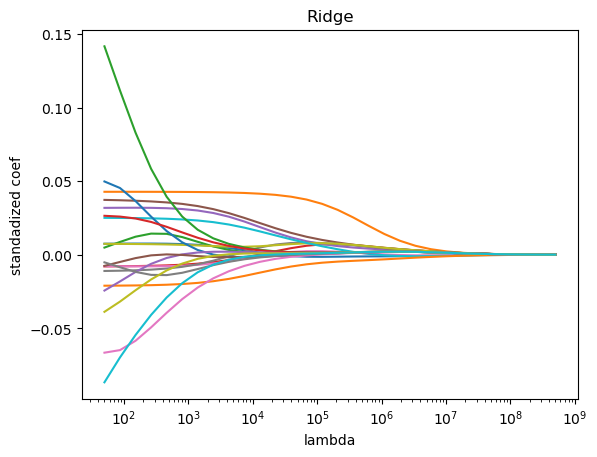

In [60]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

## Models

In [61]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)  ## FDR
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))



0.0144053979150745
(23841, 20) 23841


In [ ]:
# using manual cv iterating 5 times then taking average of 5 iterations for ['Model','Trn','Tst','OOT'] 

In [62]:
niter = 0
nitermax = 5
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

In [63]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [64]:
Modeling_output.shape

(1000, 4)

In [65]:
import warnings
warnings.filterwarnings('ignore')

In [66]:
%%time
# Logistic regression
params=['lbfgs', 'l2', 0.01]
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for i in range(0,1):
    for niter in range(nitermax):    
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

       
        model = LogisticRegression(max_iter=10,solver='lbfgs', penalty='l2', C=0.1)


        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()

        model.fit(X_trn, Y_trn.values.ravel())   

        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
        Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
        counter = counter + 1

    print(FDR3.mean())
    model_counter = model_counter + 1
    

0 0.4737219302436694 0.48665749656121043 0.4631181894383906
1 0.48439169139465876 0.46259073143495255 0.46353730092204526
2 0.49261840085036024 0.48333333333333334 0.4773679798826488
3 0.48598793898545584 0.4971830985915493 0.4765297569153395
4 0.49032640949554895 0.48659966499162477 0.47569153394803015
trn    0.485409
tst    0.483273
oot    0.471249
dtype: float64
CPU times: user 2.83 s, sys: 414 ms, total: 3.24 s
Wall time: 2.15 s


In [67]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(max_depth=10,min_samples_split=30,min_samples_leaf=20)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.5281548813599339 0.5288461538461539 0.5075440067057837
1 0.5259931627961806 0.5295119182746879 0.5062866722548198
2 0.5212602155631885 0.5406846240179574 0.5041911148365466
3 0.5234077946768061 0.5377332219437483 0.5041911148365466
4 0.5255570117955439 0.5246264526840066 0.5008382229673093
trn    0.524875
tst    0.532280
oot    0.504610
dtype: float64
CPU times: user 2.52 s, sys: 249 ms, total: 2.77 s
Wall time: 2.78 s


In [68]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(n_estimators=60,max_depth=15,min_samples_split=25,min_samples_leaf=15,max_features=5)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5335655097874384 0.5282608695652173 0.5050293378038558
1 0.5397034202343937 0.5176954732510288 0.5079631181894384
2 0.5332215970310068 0.5317460317460317 0.5075440067057837
3 0.5362561223270816 0.5228272827282728 0.5058675607711651
4 0.5337239894762019 0.5305898491083676 0.5033528918692373
trn    0.535294
tst    0.526224
oot    0.505951
dtype: float64
CPU times: user 53.8 s, sys: 2.53 s, total: 56.3 s
Wall time: 56.9 s


In [69]:
%%time
# LGBM

#params=[[15,800,5,0.04],[18,900,5,0.08],[10,1000,6,0.05],[20,600,7,0.08]]

#for i in range(0,1):
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

        model = lgb.LGBMClassifier(num_leaves=10,n_estimators=1000,max_depth=6,learning_rate=0.05)

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()

        model.fit(X_trn, Y_trn.values.ravel())   

        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
        Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
        counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1


0 0.5330656589513463 0.5218988414806442 0.5092204526404024
1 0.5295085821772866 0.5318480434161668 0.5088013411567477
2 0.5307737743650325 0.5287972896668549 0.5092204526404024
3 0.5304045966004309 0.5307966055297016 0.5071248952221291
4 0.5275935575556608 0.5369071007577884 0.5067057837384744
trn    0.530269
tst    0.530050
oot    0.508215
dtype: float64
CPU times: user 3min 12s, sys: 6.67 s, total: 3min 19s
Wall time: 39.7 s


In [70]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    
    model = MLPClassifier(activation='relu', max_iter=200,solver='lbfgs', learning_rate = 'adaptive', learning_rate_init = 0.0001, alpha = 0.0001)


  
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5322195704057279 0.514750482492418 0.5062866722548198
1 0.5285139611926172 0.5240506329113924 0.5075440067057837
2 0.5259747909058782 0.5298465036952814 0.5058675607711651
3 0.5275196568977841 0.5253252145031829 0.5058675607711651
4 0.5246428571428572 0.5339617410590518 0.5067057837384744
trn    0.527774
tst    0.525587
oot    0.506454
dtype: float64
CPU times: user 15min 4s, sys: 4min 4s, total: 19min 9s
Wall time: 5min 35s


In [71]:
%%time
# GBC

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = GradientBoostingClassifier(max_depth=4,n_estimators=200,learning_rate=0.05)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5207789123723581 0.5442119944211995 0.5050293378038558
1 0.524102079395085 0.5357042054755856 0.5037720033528919
2 0.5300070604848199 0.5223710458820177 0.5067057837384744
3 0.5263654594785891 0.5308781869688385 0.5029337803855826
4 0.5289666587845826 0.525781910397295 0.5046102263202011
trn    0.526044
tst    0.531789
oot    0.504610
dtype: float64
CPU times: user 2min 43s, sys: 5.93 s, total: 2min 49s
Wall time: 2min 50s


In [72]:
%%time
# XGB

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(max_depth=4, n_estimators=1000,learning_rate=0.05)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5366579385860509 0.521497919556172 0.5050293378038558
1 0.5367892976588629 0.5196698762035763 0.5058675607711651
2 0.5340047393364928 0.5287356321839081 0.508382229673093
3 0.5315888731730316 0.5327845586148169 0.5067057837384744
4 0.5327927498211305 0.5274785970726319 0.5058675607711651
trn    0.534367
tst    0.526033
oot    0.506370
dtype: float64
CPU times: user 38min 48s, sys: 21.2 s, total: 39min 9s
Wall time: 6min 25s


In [73]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.473722,0.486657,0.463118
1,log reg,0.484392,0.462591,0.463537
2,log reg,0.492618,0.483333,0.477368
3,log reg,0.485988,0.497183,0.47653
4,log reg,0.490326,0.4866,0.475692
5,DT,0.528155,0.528846,0.507544
6,DT,0.525993,0.529512,0.506287
7,DT,0.52126,0.540685,0.504191
8,DT,0.523408,0.537733,0.504191
9,DT,0.525557,0.524626,0.500838


In [74]:
df.shape

(35, 4)

In [75]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.473722
1,log reg,Trn,0.484392
2,log reg,Trn,0.492618
3,log reg,Trn,0.485988
4,log reg,Trn,0.490326


In [76]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.473722
1,log reg,Trn,0.484392
2,log reg,Trn,0.492618
3,log reg,Trn,0.485988
4,log reg,Trn,0.490326


In [77]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
             mean       std      mean       std      mean       std
Model                                                              
DT       0.524875  0.002631  0.532280  0.006678  0.504610  0.002549
GBC      0.526044  0.003736  0.531789  0.008592  0.504610  0.001421
LGBM     0.530269  0.001989  0.530050  0.005450  0.508215  0.001207
NN       0.527774  0.002890  0.525587  0.007214  0.506454  0.000701
RF       0.535294  0.002744  0.526224  0.005873  0.505951  0.001884
XGB      0.534367  0.002315  0.526033  0.005386  0.506370  0.001271
log reg  0.485409  0.007316  0.483273  0.012686  0.471249  0.007257

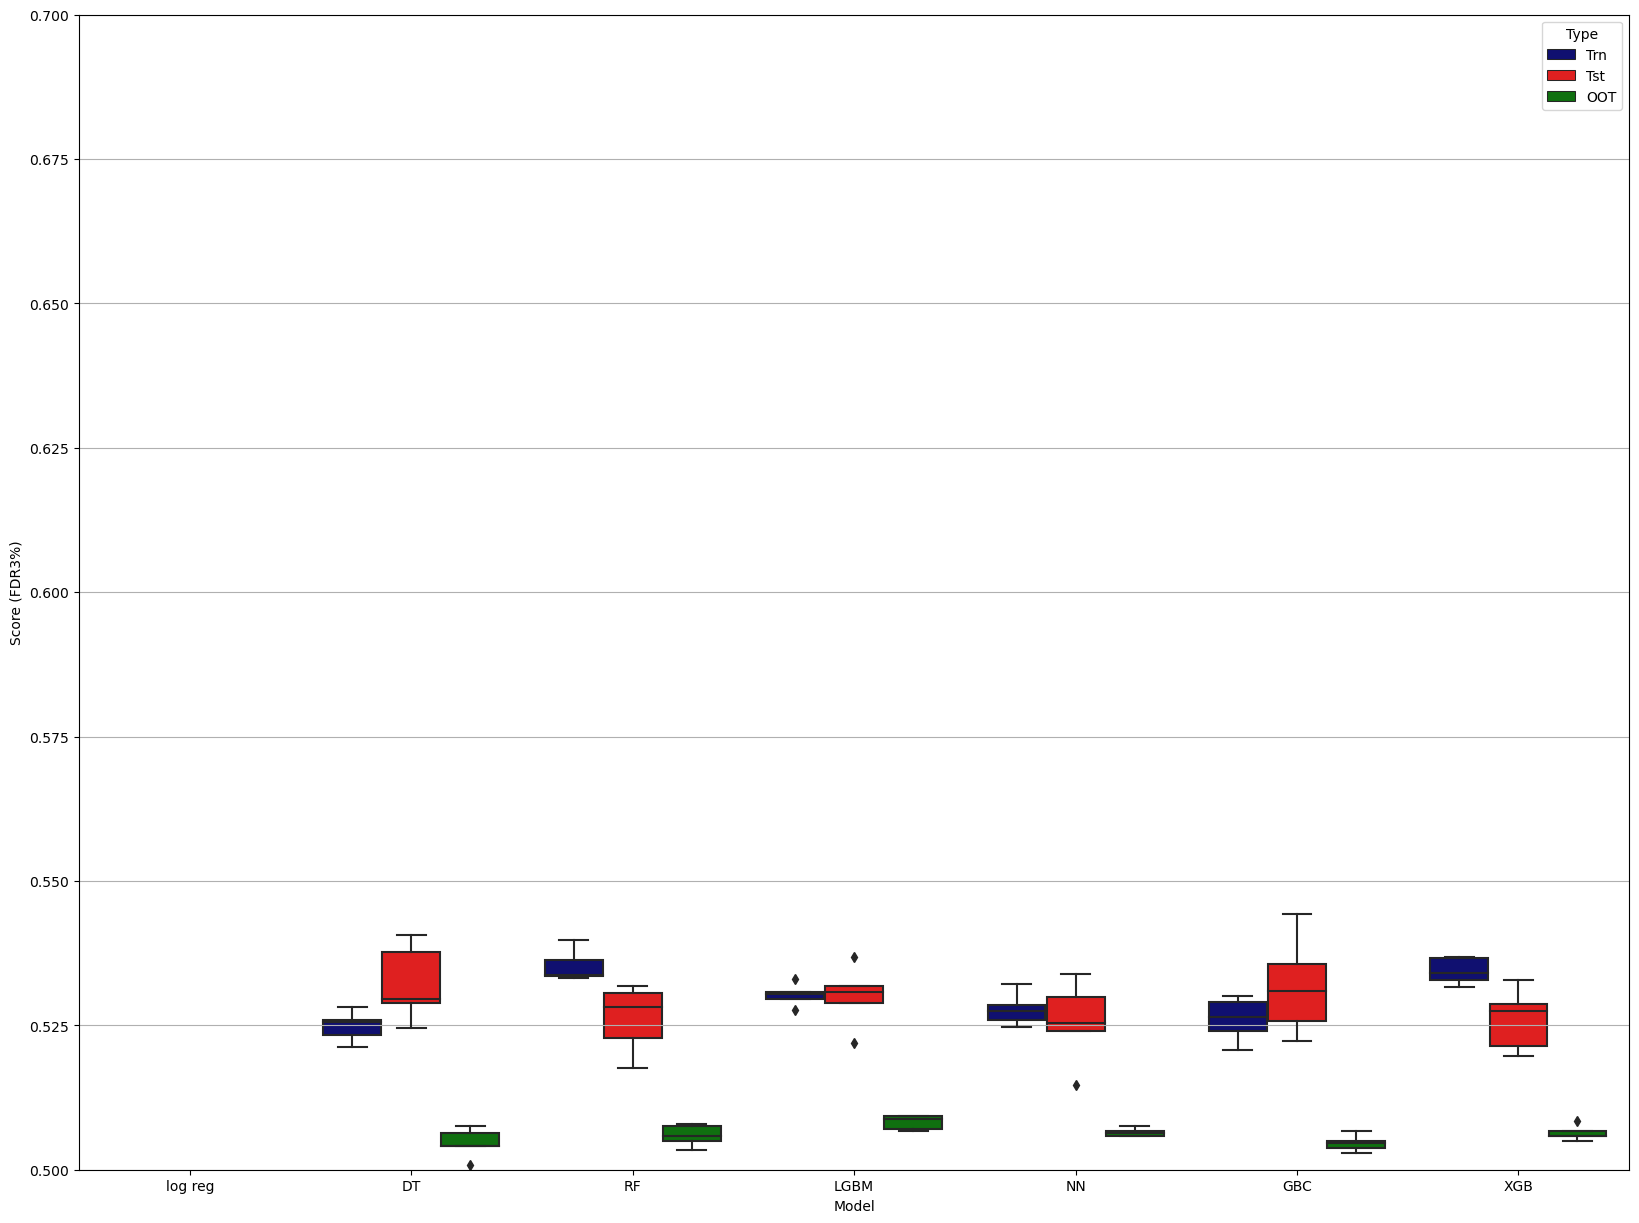

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.5,.7)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [ ]:
print('duration: ', datetime.now() - start_time)

In [79]:
%%time
# LGBM

#params=[[15,800,5,0.04],[18,900,5,0.08],[10,1000,6,0.05],[20,600,7,0.08]]

#for i in range(0,1):
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

        model = lgb.LGBMClassifier(num_leaves=10,n_estimators=1000,max_depth=6,learning_rate=0.05)

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()

        model.fit(X_trn, Y_trn.values.ravel())   

        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*0.03))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*0.03))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*0.03))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
        Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
        counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1


0 0.5366057565985907 0.5154100165107319 0.5058675607711651
1 0.5297470609191307 0.5306748466257669 0.5075440067057837
2 0.5335005374417772 0.5203632361034672 0.5088013411567477
3 0.5345501955671447 0.5218487394957984 0.508382229673093
4 0.5292211688467539 0.5313010342950463 0.5079631181894384
trn    0.532725
tst    0.523920
oot    0.507712
dtype: float64
CPU times: user 3min 12s, sys: 6.85 s, total: 3min 19s
Wall time: 40.1 s


In [80]:
%%time

for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model = lgb.LGBMClassifier(num_leaves=10,n_estimators=1000,max_depth=6,learning_rate=0.05)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .52): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5332699619771863 0.5249234196602618 0.508382229673093
1 0.5338399430064118 0.5163179916317991 0.5088013411567477
2 0.5360959392068392 0.5152022315202232 0.5058675607711651
3 0.5311447811447811 0.5256028176645895 0.5088013411567477
4 0.5345359601234275 0.5188494833845294 0.5067057837384744
5 0.5294187850578828 0.5308710033076075 0.5088013411567477
6 0.5339377311225099 0.5212472406181016 0.5062866722548198
7 0.5367638239174763 0.5147138964577657 0.508382229673093
8 0.5305689716103192 0.5304150085275725 0.5058675607711651
9 0.5316591287788621 0.5245492371705964 0.5075440067057837
10 0.5310247015719182 0.5290468133107727 0.509639564124057
11 0.5315487571701721 0.5259686727122836 0.5079631181894384
12 0.5339748158707531 0.5213151295625522 0.5092204526404024
13 0.5316259678379988 0.5274086378737541 0.5092204526404024
14 0.5320390662220105 0.526446967599003 0.5088013411567477
15 0.5310707456978967 0.5276174773289365 0.5050293378038558
16 0.5357858743072751 0.5144639818491208 0.50796311818

In [81]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [82]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)



,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,...,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60,predicted,Fraud
957048,-3.270118,32.097507,17.021802,14.771219,17.066706,18.042035,-3.043947,17.708394,18.705415,-8.379301,...,17.066277,17.062742,17.065555,16.953849,16.958535,17.004234,17.066162,17.069169,1.0,0.0
849132,-3.280209,13.990166,-0.094684,-0.052528,-0.082437,-0.069436,-3.053486,4.765118,5.048616,-6.819389,...,-0.091155,-0.091335,-0.091171,-0.098151,-0.098939,-0.095009,-0.091137,-0.090941,1.0,1.0
884916,-3.280209,-0.093321,14.169054,18.477156,15.507693,16.395538,-3.053486,16.090484,16.998315,0.200213,...,14.206705,14.203729,14.206101,14.111849,14.115623,14.154360,14.206612,14.209151,1.0,1.0
884885,-3.280209,-0.093321,12.742680,16.624188,13.948680,14.749040,-3.053486,14.472575,15.291215,0.200213,...,12.776919,12.774223,12.776374,12.690849,12.694166,12.729423,12.776838,12.779142,1.0,1.0
865902,-3.280209,-0.093321,12.742680,16.624188,13.948680,14.749040,-3.053486,14.472575,15.291215,0.200213,...,12.776919,12.774223,12.776374,12.690849,12.694166,12.729423,12.776838,12.779142,1.0,1.0
865961,-3.280209,-0.093321,14.169054,18.477156,15.507693,16.395538,-3.053486,16.090484,16.998315,0.200213,...,14.206705,14.203729,14.206101,14.111849,14.115623,14.154360,14.206612,14.209151,1.0,1.0
915077,-3.280209,-0.093321,11.316306,14.771219,12.389667,13.102543,-3.053486,12.854665,13.584116,0.200213,...,11.347133,11.344716,11.346646,11.269849,11.272710,11.304486,11.347063,11.349132,1.0,1.0
865765,-3.280209,-0.093321,11.316306,14.771219,12.389667,13.102543,-3.053486,12.854665,13.584116,0.200213,...,11.347133,11.344716,11.346646,11.269849,11.272710,11.304486,11.347063,11.349132,1.0,1.0
937013,-3.280209,-0.093321,11.316306,14.771219,12.389667,13.102543,-3.053486,12.854665,13.584116,0.200213,...,11.347133,11.344716,11.346646,11.269849,11.272710,11.304486,11.347063,11.349132,1.0,1.0
835976,-3.280209,-0.093321,11.316306,14.771219,12.389667,13.102543,-3.053486,12.854665,13.584116,0.200213,...,11.347133,11.344716,11.346646,11.269849,11.272710,11.304486,11.347063,11.349132,1.0,1.0


In [83]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,1665.0,502.0,1163.0,30.150150,69.849850,1665.0,502.0,1163.0,0.305898,48.742666,48.436768,0.431642
2,2.0,1665.0,1638.0,27.0,98.378378,1.621622,3330.0,2140.0,1190.0,1.304027,49.874267,48.570239,1.798319
3,3.0,1665.0,1641.0,24.0,98.558559,1.441441,4995.0,3781.0,1214.0,2.303985,50.880134,48.576150,3.114498
4,4.0,1665.0,1658.0,7.0,99.579580,0.420420,6660.0,5439.0,1221.0,3.314301,51.173512,47.859211,4.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,1665.0,1656.0,9.0,99.459459,0.540541,159833.0,157487.0,2346.0,95.966047,98.323554,2.357508,67.130009
97,97.0,1665.0,1654.0,11.0,99.339339,0.660661,161498.0,159141.0,2357.0,96.973926,98.784577,1.810651,67.518456
98,98.0,1665.0,1656.0,9.0,99.459459,0.540541,163163.0,160797.0,2366.0,97.983023,99.161777,1.178754,67.961538
99,99.0,1665.0,1652.0,13.0,99.219219,0.780781,164828.0,162449.0,2379.0,98.989684,99.706622,0.716938,68.284573


In [84]:
FDR3.to_csv('FDR3.csv')

In [85]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [86]:
print("duration: ", datetime.now() - start_time)

duration:  0:29:12.158087
